<a href="https://colab.research.google.com/github/KxxHyoRim/KoreanCow_Suppy_Demand_Prediction/blob/main/Korean_cow_predict_only_price_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [ ]:
#불러올 파일의 경로를 filename 변수에 저장
filename = '/content/drive/My Drive/preprocessed_unNormalized_2015_2019.csv'
#pandas read_csv로 불러오기
data = pd.read_csv(filename, encoding='cp949') # encoding : 한글 로딩 위함
data.head()
data.shape

(1235, 16)

In [ ]:
# data = data.drop(columns=['도매 가격','소비자 가격', '당해 소비자 가격','날짜'])

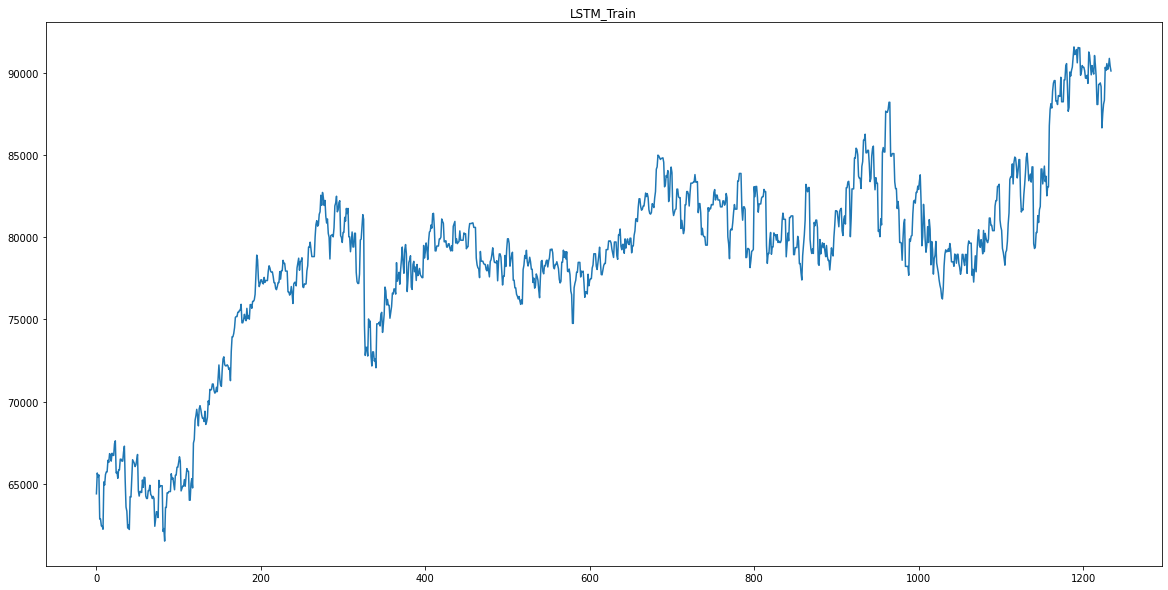

In [ ]:
import matplotlib.pyplot as plt

domae = data['당해 소비자 가격']

plt.gcf().set_size_inches(20, 10, forward=True)

start = 0
end = -1

real = plt.plot(domae, label='domae')

plt.title('LSTM_Train')
plt.show()

In [ ]:
data_length = len(data['당해 소비자 가격'].values)
print("data_length " , data_length)

seq_len = 90
sequence_length = seq_len + 30

result = []
for index in range(data_length - sequence_length):
  result.append(domae[index : index + sequence_length])

len(result)

data_length  1235


1115

In [ ]:
normalized_data = []
real_data = []

idx = 0
for window in result: 
  # print('*' * 50)
  # print(window)
  real_data.append(window[idx]) # 값 복구 위함
  normalized_window = [((float(p) / float(window[idx])) - 1) for p in window]
  normalized_data.append(normalized_window)
  # print(normalized_window)
  idx += 1

result = np.array(normalized_data)

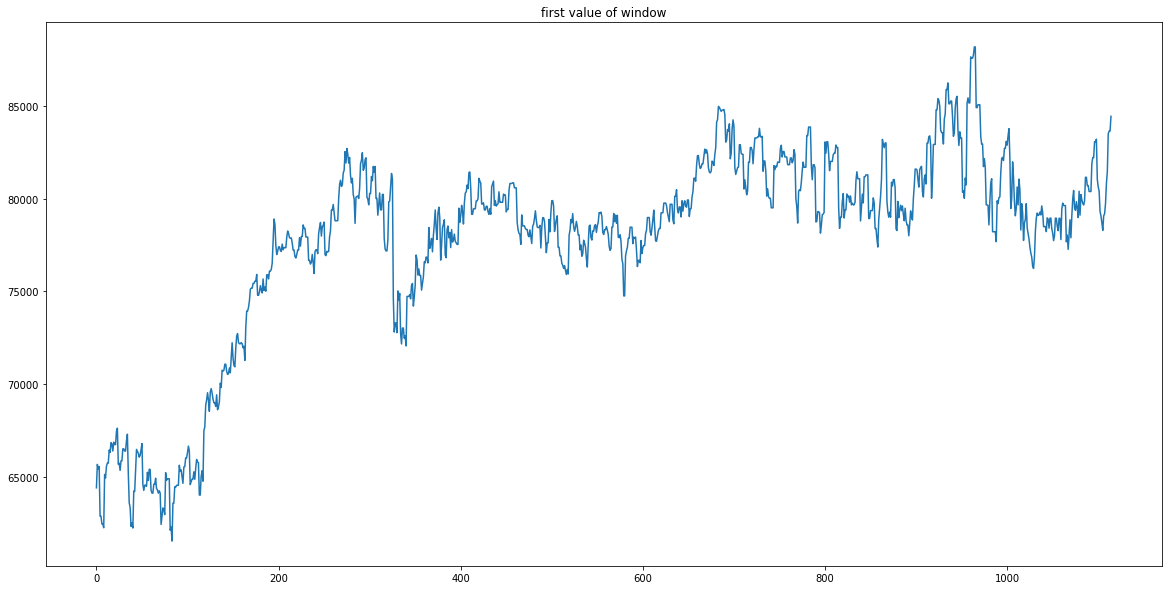

In [ ]:
real_data


plt.gcf().set_size_inches(20, 10, forward=True)

start = 0
end = -1

real = plt.plot(real_data, label='real_data')

plt.title('first value of window')
plt.show()



In [ ]:
# normalized_data = []

# idx = 0
# for window in result: 
#   normalized_window = [p for p in window]
#   normalized_data.append(normalized_window)
#   # print(normalized_window)
#   idx += 1

# result = np.array(normalized_data)

In [ ]:
# split train and test data
row = int(round(result.shape[0] * 0.8))
train = result[-row:-1, :]
# print(train)
# np.random.shuffle(train)
print(train.shape)

x_train = train[:, :90]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, 90: ]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = result[:result.shape[0]-row, :90]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[:result.shape[0]-row, 90:]

print(x_train.shape) # (939, 30, 1)
print(x_test.shape)  
print(y_train.shape)  # (939, 30)
print(y_test.shape)



(891, 120)
x_train (891, 90, 1)
y_train (891, 30)
(891, 90, 1)
(223, 90, 1)
(891, 30)
(223, 30)


In [ ]:
"""Build Model"""

model = Sequential()

model.add(LSTM(90, return_sequences=True, input_shape=(90, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(30, activation='linear'))

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 90, 90)            33120     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                39680     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1950      
Total params: 74,750
Trainable params: 74,750
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 30)



model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100,
    callbacks=[early_stopping_callback])

Epoch 1/100
90/90 [==============================] - 9s 106ms/step - loss: 5.7553e-04 - val_loss: 0.0015
Epoch 2/100
90/90 [==============================] - 10s 107ms/step - loss: 5.6082e-04 - val_loss: 0.0017
Epoch 3/100
90/90 [==============================] - 10s 108ms/step - loss: 5.4784e-04 - val_loss: 0.0014
Epoch 4/100
90/90 [==============================] - 10s 107ms/step - loss: 5.4324e-04 - val_loss: 0.0019
Epoch 5/100
90/90 [==============================] - 10s 107ms/step - loss: 5.5490e-04 - val_loss: 0.0016
Epoch 6/100
90/90 [==============================] - 10s 107ms/step - loss: 5.4629e-04 - val_loss: 0.0017
Epoch 7/100
90/90 [==============================] - 10s 107ms/step - loss: 5.2033e-04 - val_loss: 0.0019
Epoch 8/100
90/90 [==============================] - 10s 110ms/step - loss: 5.1722e-04 - val_loss: 0.0012
Epoch 9/100
90/90 [==============================] - 10s 109ms/step - loss: 5.0703e-04 - val_loss: 0.0015
Epoch 10/100
90/90 [===========================

In [ ]:
pred = model.predict(x_train)

# 1년치 데이터를 그래프로 그리기 위해 flatten
y_train = y_train.flatten()
pred = pred.flatten()

print(y_train.shape[0] // 30)

draw_real = []
draw_pred = []

# # 30일 단위로 예측을 했으므로 30일 간격을 가진 채로 이어붙이기
idx = 0
while idx < y_train.shape[0]:
  draw_real.append(y_train[idx])
  draw_pred.append(pred[idx])
  idx += 30

print(len(draw_real))

891
891


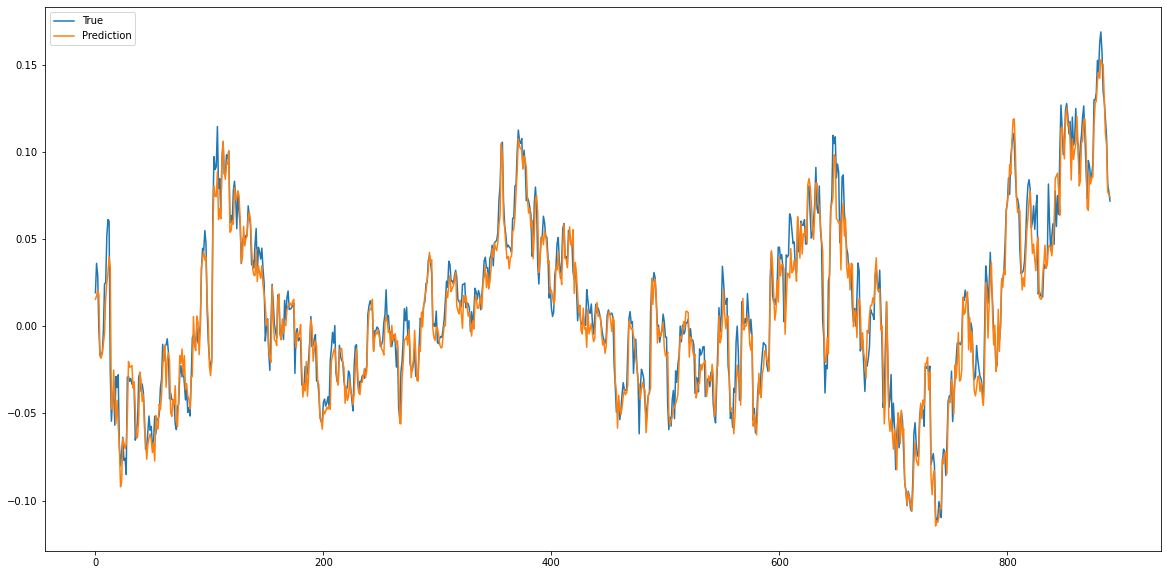

In [ ]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(draw_real, label='True')
ax.plot(draw_pred, label='Prediction')
ax.legend()
plt.show()

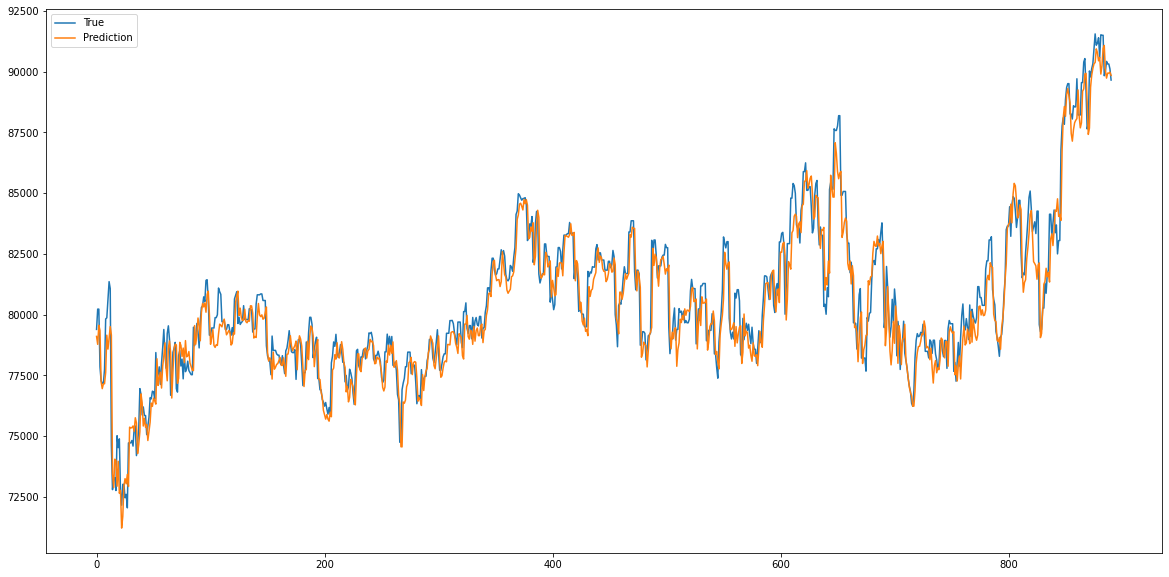

In [ ]:
real_data_train = real_data[-row:-1]
pred_data = []

r = []
p = []
idx = 0
for i in real_data_train:
  tmp = real_data_train[idx] *(draw_real[idx] + 1)
  r.append(tmp)
  tmp = real_data_train[idx] *(draw_pred[idx] + 1)
  p.append(tmp)
  idx += 1



fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(r, label='True')
ax.plot(p, label='Prediction')
ax.legend()
plt.show()

# **Test Data**

In [ ]:
pred = model.predict(x_test)

# 1년치 데이터를 그래프로 그리기 위해 flatten
y_test = y_test.flatten()
pred = pred.flatten()

print(y_test.shape[0] // 30)

draw_real = []
draw_pred = []

# # 30일 단위로 예측을 했으므로 30일 간격을 가진 채로 이어붙이기
idx = 0
while idx < y_test.shape[0]:
  draw_real.append(y_test[idx])
  draw_pred.append(pred[idx])
  idx += 30

print(len(draw_real))

223
223


**정규화전**

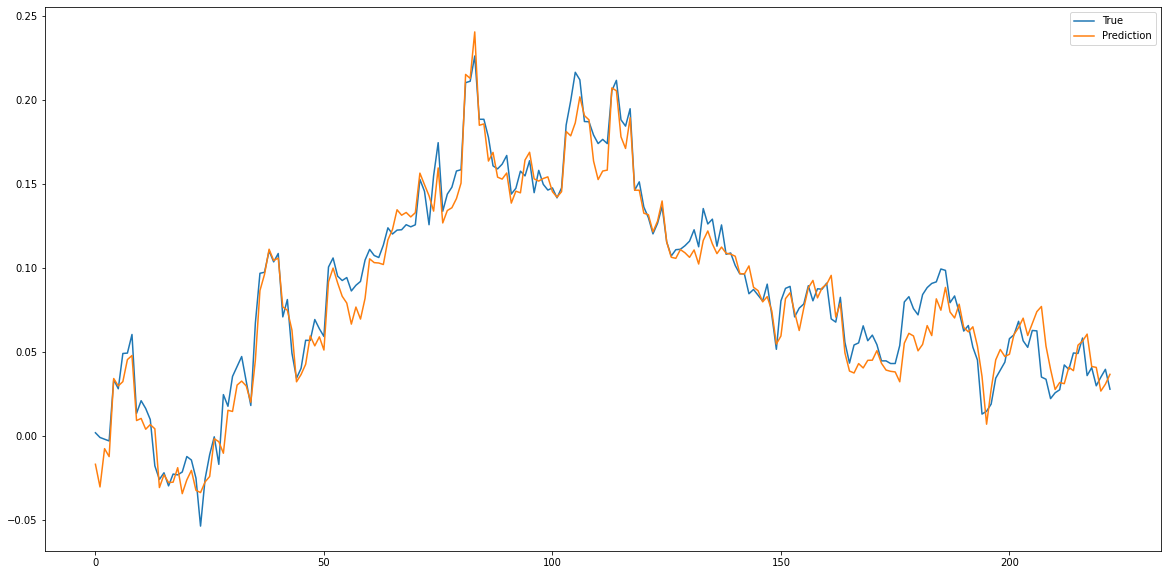

In [ ]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(draw_real, label='True')
ax.plot(draw_pred, label='Prediction')
ax.legend()
plt.show()

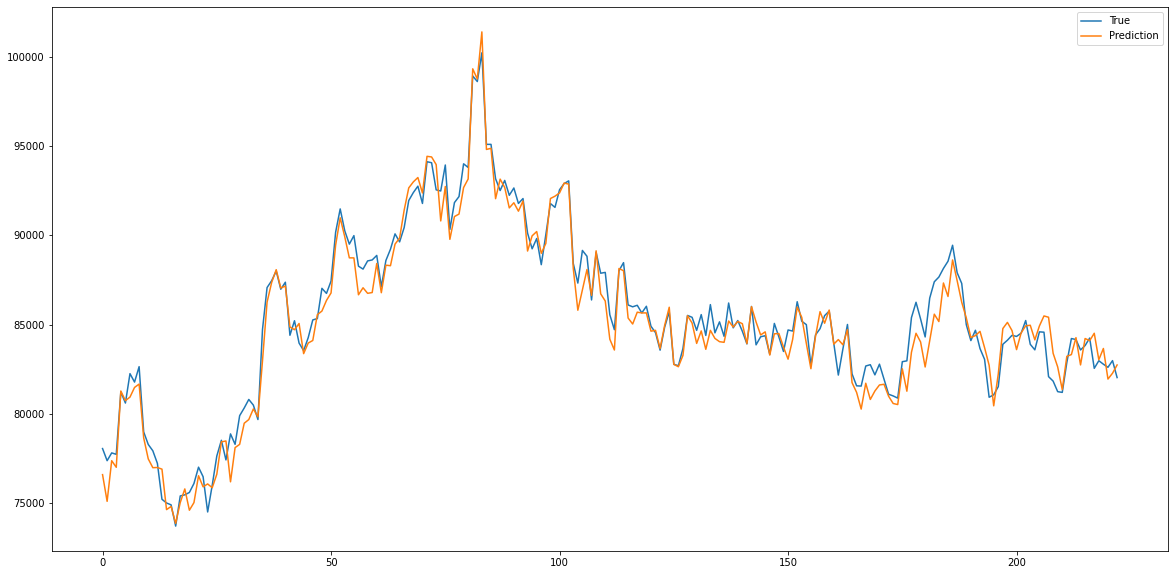

In [ ]:
real_data_test = real_data[:result.shape[0]-row]
pred_data = []


r = []
p = []
idx = 0
for i in real_data_test:
  tmp = real_data_test[idx] *(draw_real[idx] + 1)
  r.append(tmp)
  tmp = real_data_test[idx] *(draw_pred[idx] + 1)
  p.append(tmp)
  idx += 1



fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(r, label='True')
ax.plot(p, label='Prediction')
ax.legend()
plt.show()